In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import cv2
import os
import matplotlib.pyplot as plt
import nibabel as nlb
import numpy as np
from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
path = '/Users/mhd/Desktop/py/os/HGG'
flair = []
t1 = []
t2 = []
t1ce = []
seg = []
for folder in tqdm(os.listdir(path)):
    try:
        new_path = os.path.join(path, folder)
        for item in os.listdir(new_path):
            try:
                img = nlb.load(os.path.join(new_path, item)).get_fdata()
                img = img[:, :, 30:100]
                if 'seg' in item:
                    img = img.astype(np.uint8)
                    img[img == 4] = 3
                    seg.append(img)
                    
                elif't1' in item and 'ce' not in item:
                    img = img / img.max()
                    t1.append(img)
                    
                elif't1ce' in item:
                    img = img / img.max()
                    t1ce.append(img)
                    
                elif't2' in item:
                    img = img / img.max()
                    t2.append(img)
                    
                elif'flair' in item:
                    img = img / img.max()
                    flair.append(img)
                    
            except: pass
    except: pass

flair = np.array(flair)
t1 = np.array(t1)
t2 = np.array(t2)
t1ce = np.array(t1ce)
seg = np.array(seg)

100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  4.13it/s]


In [5]:
print(flair.shape)
print(t1.shape)
print(t2.shape)
print(t1ce.shape)
print(seg.shape)

(14, 240, 240, 70)
(13, 240, 240, 70)
(13, 240, 240, 70)
(13, 240, 240, 70)
(13, 240, 240, 70)


[0 1 2 3]
[56682   141   392   385]


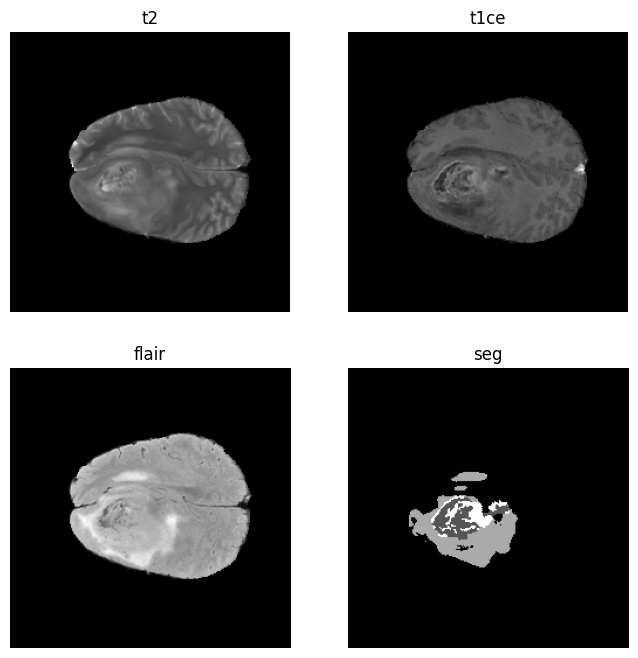

In [6]:
n = np.random.randint(0, 70)
m = np.random.randint(0, 13)
category = [t2, t1ce, flair, seg]
cat = ['t2', 't1ce', 'flair', 'seg']

fig = plt.figure(figsize=(8, 8))
rows, cols = 2, 2
i = 0
for item in category:
    fig.add_subplot(rows, cols, i+1)
    plt.title(f'{cat[i]}')
    plt.imshow(item[m][:,:,n], cmap = 'gray')
    plt.axis(False)
    i += 1
val, count = np.unique(seg[7][:,:,n], return_counts=True)
print(val)
print(count)

In [22]:
flair_new = np.moveaxis(flair, -1, 1,)
t1ce_new = np.moveaxis(t1ce,-1, 1)
label = np.moveaxis(seg, -1, 1)
flair_new.shape, t1ce_new.shape, label.shape

((14, 70, 240, 240), (13, 70, 240, 240), (13, 70, 240, 240))

In [1]:
# crop dark section of images 
train_data = []
test_data = []
for k in tqdm(range(10)):
    for i in range(flair_new.shape[1]):  
        for j in range(60, flair_new.shape[2]-40):
            X1 = torch.tensor(flair_new[k, i , j-20:j+20, j-20:j+20], dtype=torch.float)
            X2 = torch.tensor(t1ce_new[k, i, j-12:j+13, j-12:j+13], dtype=torch.float)
            y = torch.tensor(label[k, i, j, j], dtype=torch.float)
            train_data.append([X1.unsqueeze(dim=0), X2.unsqueeze(dim=0), y.reshape((1,)).to(torch.long)])
            

for k in tqdm(range(10,11)):
    for i in range(flair_new.shape[1]):  
        for j in range(60, flair_new.shape[2]-40):
            X1 = torch.tensor(flair_new[k, i , j-20:j+20, j-20:j+20], dtype=torch.float)
            X2 = torch.tensor(t1ce_new[k, i, j-12:j+13, j-12:j+13], dtype=torch.float)
            y = torch.tensor(label[k, i, j, j], dtype=torch.float)
            test_data.append([X1.unsqueeze(dim=0), X2.unsqueeze(dim=0), y.reshape((1,)).to(torch.long)])
            

NameError: name 'tqdm' is not defined

In [ ]:
# a = train_data[0][1]
# a = a.unsqueeze(dim=0)
# a.shape
len(train_data), len(test_data)

In [ ]:
# train_data_batch = torch.utils.data.DataLoader(train_data, 70)
# test_data_batch = torch.utils.data.DataLoader(test_data, 42)
# len(train_data_batch), len(test_data_batch)

In [9]:
class TumorCNN(nn.Module):
  """
  get two input with shapes : (N, 1, 40, 40) and (N, 1, 25, 25) in row, 
  we want concat them after some Conv layers
  """
  def __init__(self):
    super().__init__()
    self.Higher = nn.Sequential(
        # input (1, 40 40)
        nn.Conv2d(1, 32, kernel_size=3, padding='same', stride=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        # output (32, 40, 40)

        nn.Conv2d(32, 64, kernel_size=3, padding='same', stride=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # output (64, 40, 40)

        nn.MaxPool2d(kernel_size=2),
        # output (64, 20, 20)

        nn.Conv2d(64, 128, kernel_size=5, padding='same', stride=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # output (128, 20, 20)

        nn.MaxPool2d(kernel_size=2)
        # output (128, 10, 10)
    )

    self.Lower = nn.Sequential(
        # input (1, 25, 25)
        nn.Conv2d(1, 64, kernel_size=3, padding='same', stride=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # output (64, 25, 25)

        nn.Conv2d(64, 128, kernel_size=5, padding=0, stride=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # output (128, 21, 21)

        nn.MaxPool2d(kernel_size=2)
        # output (128, 10, 10)
    )

    self.cat = nn.Sequential(
        nn.Conv2d(2*128, 256, kernel_size=1, padding='same', stride=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # output (256, 10, 10)

        nn.Conv2d(256, 256, kernel_size=3, padding='same', stride=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # output (256, 10, 10)
        nn.MaxPool2d(kernel_size=2)
        # output (256, 5, 5)
    )

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*5*5, 128),
        nn.ReLU(),
        nn.Linear(128, 4),
        nn.Softmax()
    )

  def forward(self, x: torch.tensor, y: torch.tensor):
    HigherOut = self.Higher(x)
#     print(HigherOut.shape)

    LowerOut = self.Lower(y)
#     print(LowerOut.shape)

    output = torch.cat([HigherOut, LowerOut], 1)
#     print(output.shape)

    output = self.cat(output)
#     print(output.shape)

    output = self.fc(output)
#     print(output.shape)
    
    return output


In [13]:
model = TumorCNN().to(device)
x = torch.rand((1, 1, 40, 40))

y = torch.rand((1, 1, 25, 25))

model(x.to(device), y.to(device))

tensor([[0.1818, 0.2088, 0.2408, 0.3685]], grad_fn=<SoftmaxBackward0>)

In [14]:
writer = SummaryWriter('runs/tumor')
writer.add_graph(model, (x.to(device), y.to(device)))

In [ ]:
model = TumorCNN()
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

def accuracy_fn(true, pred):
  correct = torch.eq(true, pred)
  return (torch.sum(correct)/len(true))*100

In [ ]:
model(train_data[0][0].unsqueeze(dim=0), train_data[0][1].unsqueeze(dim=0))

In [ ]:
len(train_data), len(test_data)

In [ ]:
from time import time
torch.manual_seed(42)
start = time()

for epoch in range(1, 4):
    countt = 0
    print(f'Epoch: {epoch}\n-------')
    train_loss = 0
    train_acc = 0
    for (X1, X2, y) in train_data:
        countt += 1
        X1, X2, y = X1.unsqueeze(dim=0), X2.unsqueeze(dim=0), y
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)
        model.train()

        y_logit = model(X1, X2)
        
        loss = loss_fn(y_logit, y)
        train_loss += loss

        accuracy = accuracy_fn(y, y_logit.argmax(dim=1))
        train_acc += accuracy

        opt.zero_grad()
        loss.backward()
        opt.step()
        if countt % 1000 == 0:
          print(f' batch: {countt} of {len(train_data)} sample')

    train_loss /= len(train_data)
    train_acc /= len(train_data)
    print(f'\nTrain loss: {train_loss} -- Train accuracy: {train_acc}\n')

    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for (X1_t, X2_t, y_t) in test_data:
            X1_test, X2_test, y_test = X1_t.unsqueeze(dim=0), X2_t.unsqueeze(dim=0), y_t
            X1_test, X2_test, y_test = X1_test.to(device), X2_test.to(device), y_test.to(device)
            y_test_logit = model(X1_test, X2_test)

            test_loss += loss_fn(y_test_logit, y_test)
            test_acc += accuracy_fn(y_test, y_test_logit.argmax(dim=1))

        test_loss /= len(test_data)
        test_acc /= len(test_data)
        print(f'Test loss: {test_loss} -- Test accuracy: {test_acc}\n')
        print(f'Time: {time() - start:.3f} seconds\n')